# Import libraries and read csv

In [2]:
import re
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
hero_netw = pd.read_csv('./hero-network.csv')
edges = pd.read_csv('./edges.csv')
nodes = pd.read_csv('./nodes.csv')

In [4]:
hero_netw

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


# Data Preprocessing

**As always, in the data science area, you can find some inconsistencies in the provided data. Therefore, some modifications should be made to the data to make it consistent across all of the datasets you have. To ensure consistency in the data, keep the following in mind:**
- Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
- Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
- Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
- The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

- Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.


In [5]:
def preprocessing(df):
    """
    Trim whitespace, replace backspace from ends of each value across all series in dataframe
    """
    replace_backspace = lambda x: re.sub(r'/$', '', x)
    trim_strings = lambda x: x.strip()
    df = df.applymap(replace_backspace).applymap(trim_strings)
    df.drop(df[df['hero1'] == df['hero2']].index, inplace=True)
    replace_name = lambda x: re.sub(r'PETER PAR$', 'PETER PARKER', x)
    return df.applymap(replace_name)

In [6]:
hero_netw = preprocessing(hero_netw)
hero_netw

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


# Graphs setup

**For this homework, we are going to build two different graphs:**

- First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

- Second graph: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [7]:
weights = hero_netw.groupby(hero_netw.columns.tolist()).size().reset_index().rename(columns={0: 'weight'})
weights

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1
...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1
224095,ZZZAX,"ROSS, GEN. THADDEUS",2
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1
224097,ZZZAX,TIGRA/GREER NELSON,1


In [8]:
hero_netw_weighted = pd.merge(hero_netw, weights, on=['hero1', 'hero2'])

In [9]:
hero_netw_weighted_for_graph = hero_netw_weighted.drop_duplicates()
hero_netw_weighted_for_graph[(hero_netw_weighted_for_graph['hero1']=='LITTLE, ABNER') & (hero_netw_weighted_for_graph['hero2']=='PRINCESS ZANDA')]

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5


In [10]:
hero_netw_weighted_for_graph[(hero_netw_weighted_for_graph['hero1']=='PRINCESS ZANDA') & (hero_netw_weighted_for_graph['hero2']=='LITTLE, ABNER')]

,hero1,hero2,weight
163,PRINCESS ZANDA,"LITTLE, ABNER",3


In [11]:
G1 = nx.from_pandas_edgelist(hero_netw_weighted_for_graph,'hero1','hero2', edge_attr='weight', create_using=nx.MultiGraph())

In [12]:
G1['LITTLE, ABNER']['PRINCESS ZANDA']

AtlasView({0: {'weight': 5}, 1: {'weight': 3}})

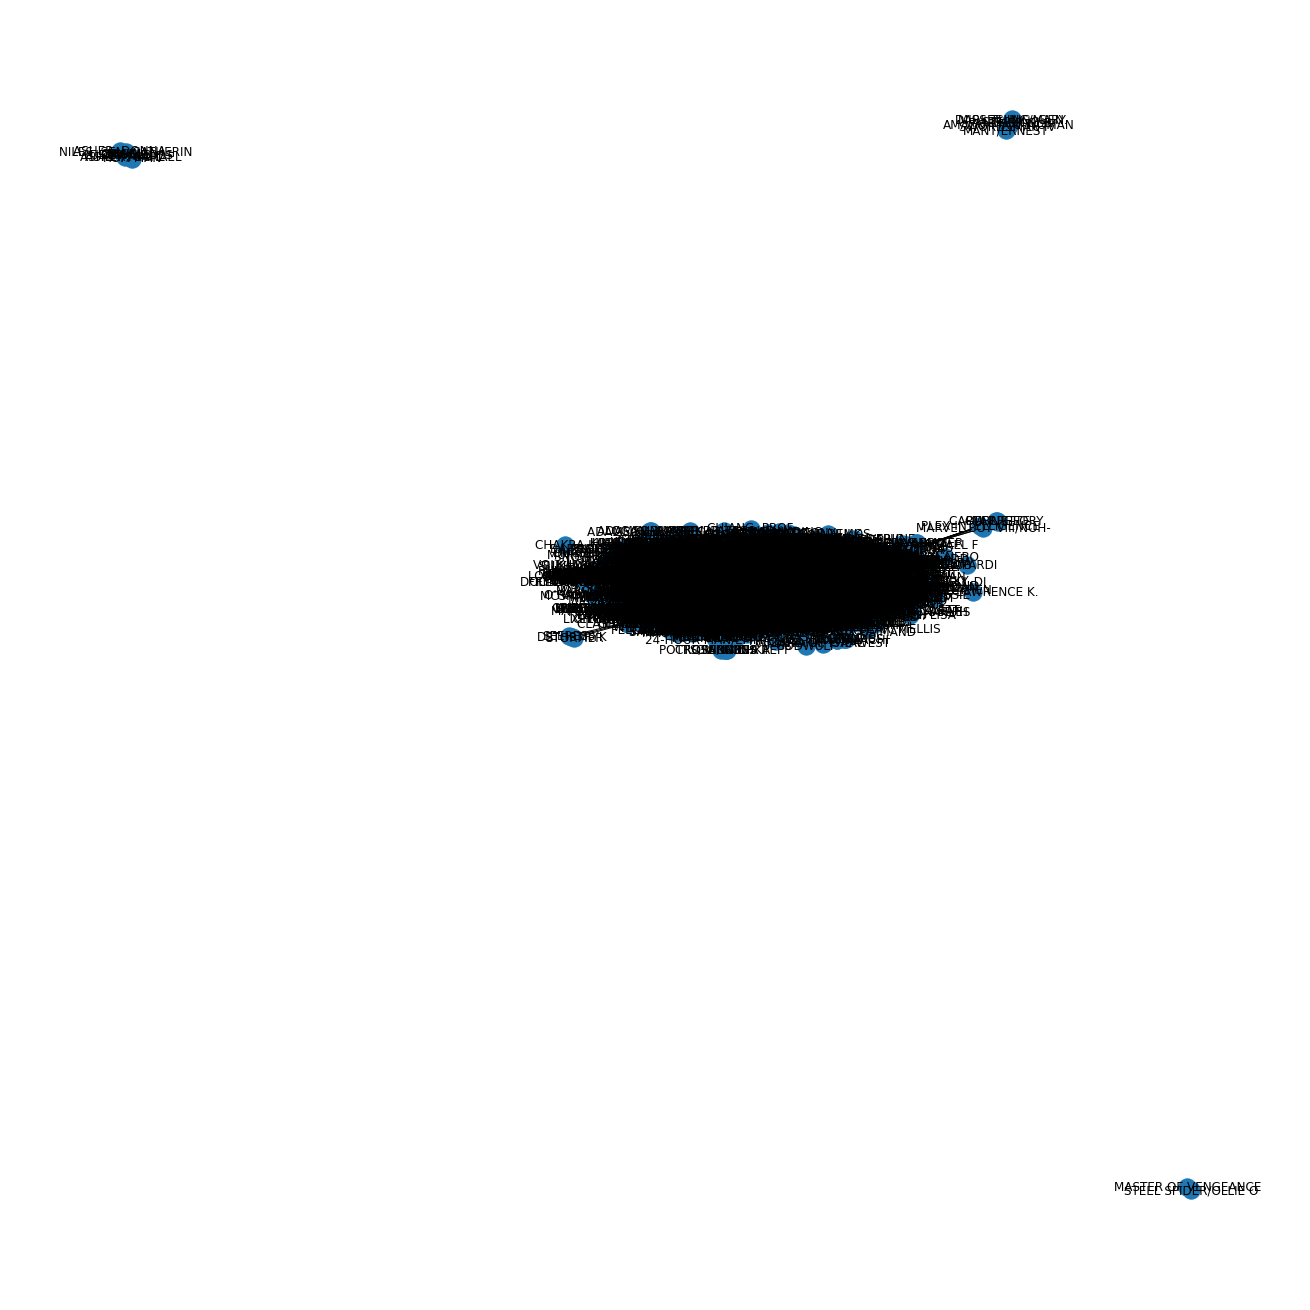

In [13]:
fig = plt.figure(figsize=(18,18))
nx.draw(G1, with_labels=True, node_size=300)
plt.show()

In [63]:
node_attr = nodes.set_index('node').to_dict('index')
node_attr

{'2001 10': {'type': 'comic'},
 '2001 8': {'type': 'comic'},
 '2001 9': {'type': 'comic'},
 '24-HOUR MAN/EMMANUEL': {'type': 'hero'},
 '3-D MAN/CHARLES CHAN': {'type': 'hero'},
 '4-D MAN/MERCURIO': {'type': 'hero'},
 '8-BALL/': {'type': 'hero'},
 "A '00": {'type': 'comic'},
 "A '01": {'type': 'comic'},
 'A 100': {'type': 'comic'},
 'A 101': {'type': 'comic'},
 'A 102': {'type': 'comic'},
 'A 103': {'type': 'comic'},
 'A 104': {'type': 'comic'},
 'A 105': {'type': 'comic'},
 'A 106': {'type': 'comic'},
 'A 107': {'type': 'comic'},
 'A 108': {'type': 'comic'},
 'A 109': {'type': 'comic'},
 'A 10': {'type': 'comic'},
 'A 110': {'type': 'comic'},
 'A 111': {'type': 'comic'},
 'A 112': {'type': 'comic'},
 'A 113': {'type': 'comic'},
 'A 114': {'type': 'comic'},
 'A 115': {'type': 'comic'},
 'A 116': {'type': 'comic'},
 'A 117': {'type': 'comic'},
 'A 118': {'type': 'comic'},
 'A 119': {'type': 'comic'},
 'A 11': {'type': 'comic'},
 'A 120': {'type': 'comic'},
 'A 121': {'type': 'comic'},
 '

In [64]:
G2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')
nx.set_node_attributes(G2, node_attr)

# 2. Backend Implementation

**The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.**

**Definition: As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for top N heros. We define the top N heroes as follows:**

   - Top N heroes: The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.

**Note: When the value of N is not set by the user, the function should consider the whole data.**

# Functionality 1 - extract the graph's features

**Input:**
   - The graph data
   The graph type (ex., number 1 or number 2)
   N: denoting the top N heroes that their data should be considered

**Output:**
   - The number of nodes in the network (if type 2, report for both node types)
   - The number of collaborations of each superhero with the others (only if type 1)
   - The number of heroes that have appeared in each comic (only if type 2)
   - The network's density
   - The network's degree distribution
   - The average degree of the network
   - The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
   - Whether the Network is sparse or dense

**Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.**

In [65]:
# FIND OUTLIERS AND FIX
labels = {}
for n, d in G2.nodes(data=True):
    try:
        l = d["type"]
        labels[l] = labels.get(l, [])
    except KeyError as e:
        print(n)
        continue;

nodes.at[14618, "node"]='SPIDER-MAN/PETER PARKER'

In [66]:
heroes_appearances = edges.groupby('hero').count().reset_index().rename(columns={'comic':'comic_appearance'}).sort_values(by='comic_appearance', ascending=False).reset_index(drop=True)
heroes_appearances

,hero,comic_appearance
0,SPIDER-MAN/PETER PARKER,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
...,...,...
6434,"LEASH, MICAH",1
6435,LEATHER/,1
6436,SERSI | MUTANT X-VER,1
6437,"LEE, LITTLE LARRY",1


In [67]:
def get_n_most_heroes(N):
    if N is not None:
        data = heroes_appearances.iloc[0:N].hero
    else:
        data = heroes_appearances.hero
    return data

In [68]:
def convert(tup, d):
    for a, b in tup:
        d.setdefault(b, []).append(a)
    return d

In [69]:
def extract_graph_features(G, type, N):
    if type == 1 :
        return extract_graph1_features(G, N)
    elif type == 2 :
        return extract_graph2_features(G, N)

In [70]:
def extract_graph1_features(G, N):
    max_num_edges = G.number_of_nodes() * (G.number_of_nodes() - 1)/2
    hero_nodes = get_n_most_heroes(N)
    print("Graph is type 1. Its features are...")
    print('⸻' * 25)
    print("Number of nodes:", G.number_of_nodes())
    print('---' * 10)
    for hero in hero_nodes:
        print("The number of collaborations of ", hero, ":", len(G1.edges(hero)))
    print('---' * 10)
    print("Graph density: ", round(nx.density(G),2))
    print('---' * 10)
    print("The network’s degree distribution")
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    fig = plt.figure("Degree of a random graph", figsize=(4, 4))
    ax = fig.add_subplot()
    ax.bar(*np.unique(degree_sequence, return_counts=True))
    ax.set_title("Degree histogram")
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")
    fig.tight_layout()
    plt.show()
    print('---' * 10)
    total_degree=0
    for hero, degree in G.degree():
        total_degree+=degree
    print("Graph average degree connectivity: ",round(total_degree/G.number_of_nodes(),2))
    print('---' * 10)
    print("The network’s Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)")
    hist = np.unique(degree_sequence)
    percentile_95 = np.percentile(hist, 95)
    hubs = [node for node in G.nodes() if G.degree(node) > percentile_95]
    sub_G = G.subgraph(hubs)
    nx.draw(sub_G, with_labels=True, node_size=300)
    plt.show()
    print('---' * 10)
    print("Is the graph dense or sparse? if density > 1/2 then graph is dense. Density is equal to the number of edges divided by the maximum number of edges available in the graph which is equal to N(number of nodes) * (N-1)/2")
    density = G.number_of_edges()/max_num_edges
    print("\nGraph is sparse " if density <= 1/2 else "\nGraph is dense")

In [95]:
def extract_graph2_features(G, N):
    max_num_edges = G.number_of_nodes() * (G.number_of_nodes() - 1)/2
    hero_nodes = get_n_most_heroes(N)
    print("Graph is type 2. Its features are...")
    print('⸻' * 25)
    print("Number of hero nodes:", len([x for x,y in G2.nodes(data=True) if y['type'] == 'hero']))
    print("Number of comic nodes:", len([x for x,y in G2.nodes(data=True) if y['type'] == 'comic']))
    print('---' * 10)
    d = {}
    for hero in hero_nodes:
        convert(G.edges(hero),d)
    for comic, heroes_list in d.items():
        print("Number of heroes appeared on comic ", comic, ":", len(heroes_list))
    print('---' * 10)
    print("Graph density: ", round(nx.density(G),3))
    print('---' * 10)
    print("The network’s degree distribution")
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    fig = plt.figure("Degree of a random graph", figsize=(4, 4))
    ax = fig.add_subplot()
    ax.bar(*np.unique(degree_sequence, return_counts=True))
    ax.set_title("Degree histogram")
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")
    fig.tight_layout()
    plt.show()
    print('---' * 10)
    total_degree=0
    for hero, degree in G.degree():
        total_degree+=degree
    print("Graph average degree connectivity: ",round(total_degree/G.number_of_nodes(),2))
    print('---' * 10)
    print("The network’s Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)")
    hist = np.unique(degree_sequence)
    percentile_95 = np.percentile(hist, 95)
    hubs = [node for node in G2.nodes(data=True) if G2.degree(node[0]) > percentile_95 and node[1]['type']=='comic']
    if hubs :
        sub_G = G.subgraph(hubs)
        nx.draw(sub_G, with_labels=True, node_size=300)
        plt.show()
    else:
        print("\nThere are no comic hubs in this graph")
    print('---' * 10)
    print("Is the graph dense or sparse? if density > 1/2 then graph is dense. Density is equal to the number of edges divided by the maximum number of edges available in the graph which is equal to N(number of nodes) * (N-1)/2")
    density = G.number_of_edges()/max_num_edges
    print("\nGraph is sparse" if density <= 1/2 else "\nGraph is dense")

Graph is type 2. Its features are...
⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻
Number of hero nodes: 6439
Number of comic nodes: 12651
------------------------------
Number of heroes appeared on comic  A 11 : 4
Number of heroes appeared on comic  A 118 : 5
Number of heroes appeared on comic  A 1.5 : 4
Number of heroes appeared on comic  A 168 : 4
Number of heroes appeared on comic  A 221 : 4
Number of heroes appeared on comic  A 235 : 2
Number of heroes appeared on comic  A 236 : 2
Number of heroes appeared on comic  A 237 : 2
Number of heroes appeared on comic  A 258 : 2
Number of heroes appeared on comic  A 298 : 2
Number of heroes appeared on comic  A 3 : 4
Number of heroes appeared on comic  A3 1 : 5
Number of heroes appeared on comic  A3 10 : 5
Number of heroes appeared on comic  A3 11 : 5
Number of heroes appeared on comic  A 314 : 4
Number of heroes appeared on comic  A 315 : 3
Number of heroes appeared on comic  A 316 : 4
Number of heroes appeared on comic  A 317 : 4
Number of heroes appeared 

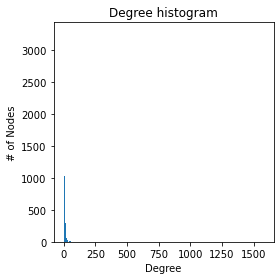

------------------------------
Graph average degree connectivity:  10.07
------------------------------
The network’s Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)

There are no comic hubs in this graph
------------------------------
Is the graph dense or sparse? if density > 1/2 then graph is dense. Density is equal to the number of edges divided by the maximum number of edges available in the graph which is equal to N(number of nodes) * (N-1)/2

Graph is sparse


In [96]:
extract_graph_features(G2, 2, 5)

# Functionality 2 - Find top superheroes!

**Input:**
- The graph data
- A node (hero or comic)
- One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
- N: denoting the top N heroes that their data should be considered

**Output:**
- The metric's value over the considered graph
- The given node's value

**Note: Give an explanation regarding the features of the user based on all of the metrics (e.g. if the betweenness metric is high, what does this mean in practice, what if the betweenness is low but has a high PageRank value, etc.).**